In [16]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np

# Random Agent

In [58]:
import numpy as np

# Initialize the game
game = MineSweeperEasy()
done = False
obs, info = game.reset()
print(game.observation_space.n)
print(game.action_space.nvec)
print(np.prod(game.action_space.nvec))
reward = -float("inf")
# game.render()
done = False

def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

    
while not done:
    # Select a random action
    action_int = (np.random.randint(0, 4), np.random.randint(0, 4))
    print('intput', action_int)
    
    # Take a step in the game
    obs, reward, truncated, terminated, info = game.step(action_int)
    done = truncated or terminated
    
    if done:
        obs2 = construct_obs(action_int, -2)
    else:
        obs2 = construct_obs(action_int, obs)
    
    # Display the type of observation and the reward
    print('obs', obs2)
    game.render()  
    print("reward:", reward)


3
[4 4]
16
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 . . . .
 . . . .
 . . . .
reward: 0.07142857142857142
intput (1, 0)
obs [-1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 . . . .
reward: 0.07142857142857142
intput (3, 0)
obs [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: 0.07142857142857142
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (1, 0)
obs [-1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 . . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (0, 0)
obs [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 0 . 1 .
 0 . . .
 . . . .
 0 . . .
reward: 0.07142857142857142
intput (0, 2)
obs [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 0 . 1 .
 0 . . .
 . . . .
 0 . . .
reward: -0.041666666666666664
intput (0, 1)
obs [-1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

# Train PPO agent

Input dimension: 16
Action dimension: 16
Model checkpoint saved at episode 2000
Model checkpoint saved at episode 4000
Model checkpoint saved at episode 6000
Model checkpoint saved at episode 8000
Model checkpoint saved at episode 10000
[-0.5, -0.42857142857142855, -0.42857142857142855, 0.5059523809523808, -0.3571428571428571, -0.5, -0.13690476190476197, -0.38095238095238093, -0.47023809523809523, -0.22619047619047616, -0.22619047619047628, -0.5714285714285714, -0.3988095238095238, -0.369047619047619, -0.4107142857142857, -0.5714285714285714, -0.22619047619047622, -0.5714285714285714, -0.3988095238095238, -0.13690476190476203, -0.25595238095238093, -0.5714285714285714, -0.5714285714285714, -0.3571428571428571, 0.029761904761904656, -0.5714285714285714, -0.011904761904761973, -0.5714285714285714, 0.3928571428571428, -0.2857142857142857, -0.13690476190476197, -0.25595238095238093, -0.47023809523809523, -0.2857142857142857, -0.5, -0.5714285714285714, 0.2797619047619046, 0.5059523809523808

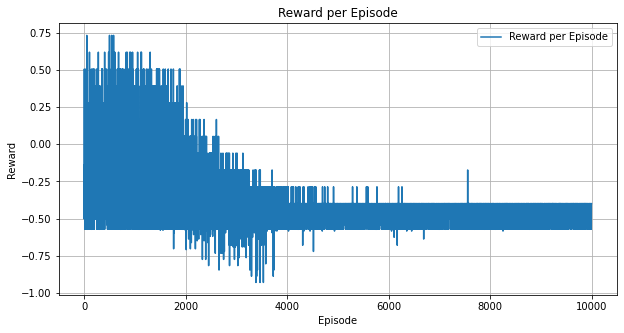

In [81]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import popgym
from popgym.envs.minesweeper import MineSweeperEasy
from collections import deque
import random
import matplotlib.pyplot as plt


    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define checkpoint directory 
checkpoint_dir = "./checkpoints" 
os.makedirs(checkpoint_dir, exist_ok=True)

# Define hyperparameters
gamma = 0.99          # Discount factor
epsilon = 0.2         # Clipping epsilon for PPO
lr = 3e-4             # Learning rate
num_episodes = 10000   # Number of episodes to train
update_timestep = 2048  # Number of timesteps to update policy
k_epochs = 10         # Number of epochs per PPO update
minibatch_size = 64   # Minibatch size for updating

reward_list = []

# Fix obs space
# array of 16. for each: -1 = not viewed; -2 = mine; 0-inf = how many neighbor mines
def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

def int_to_tuple(n):
    if not (0 <= n < 16):
        raise ValueError("Input must be an integer between 0 and 15.")
    
    # Calculate the row and column from the integer
    row = n // 4
    col = n % 4
    return (row, col)

# Define neural network for policy and value approximation
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()
        
        # Policy network
        self.policy = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )
        
        # Value network
        self.value = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, state):
        # Policy logits and state value
        policy_logits = self.policy(state)
        state_value = self.value(state)
        return policy_logits, state_value

    def act(self, state):
        policy_logits, _ = self.forward(state)
        action_probs = torch.softmax(policy_logits, dim=-1)
        action = torch.distributions.Categorical(action_probs).sample()
#         return action.item(), action_probs[:, action.item()].item()
        return action.item(), action_probs[action.item()].item()

# PPO Algorithm
class PPO:
    def __init__(self, input_dim, action_dim):
        self.policy = ActorCritic(input_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def compute_gae(self, rewards, values, masks):
        returns = []
        gae = 0
        with torch.no_grad():
            #GAE wasn't working after 250 episodes...so had to change it
#             for step in reversed(range(len(rewards))):
#                 delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
#                 gae = delta + gamma * gae * masks[step]
#                 returns.insert(0, gae + values[step])
            for step in reversed(range(len(rewards))):
                if step == len(rewards) - 1:
                    next_value = 0
                else:
                    next_value = values[step + 1]
                delta = rewards[step] + gamma * next_value * masks[step] - values[step]
                gae = delta + gamma * gae * masks[step]
                returns.insert(0, gae + values[step])
        return returns

    def update(self, memory):
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.tensor(memory.actions).to(device).detach()
        old_log_probs = torch.tensor(memory.log_probs).to(device).detach()
        rewards = torch.tensor(memory.rewards).to(device).detach()
        masks = torch.tensor(memory.dones).to(device).detach()

        # Compute advantage
        with torch.no_grad():
            _, values = self.policy(old_states)
            returns = self.compute_gae(rewards, values, masks)
            returns = torch.cat(returns).to(device)
            advantages = returns - values[:-1]

        # Update policy
        for _ in range(k_epochs):
            policy_logits, state_values = self.policy(old_states)
            dist = torch.distributions.Categorical(logits=policy_logits)
            new_log_probs = dist.log_prob(old_actions)

            # Compute ratio
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Clipped objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            # Critic loss (value function)
            critic_loss = nn.MSELoss()(state_values.squeeze(-1), returns)

            # Total loss
            loss = actor_loss + 0.5 * critic_loss

            # Backpropagate and update parameters
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# Memory for PPO
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []

    def store(self, state, action, log_prob, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []

# Main training loop
env = MineSweeperEasy()
env.reset()

init_obs = construct_obs((0,0),-1)

input_dim = init_obs.shape[0] 
action_dim = np.prod(env.action_space.nvec)

print(f"Input dimension: {input_dim}") 
print(f"Action dimension: {action_dim}")

ppo_agent = PPO(input_dim, action_dim)
memory = Memory()

timestep = 0
for episode in range(num_episodes):
    env.reset()
    state = torch.tensor(construct_obs((0,0),-1), dtype=torch.float32).to(device)
#     print("Initial state shape:", state.shape)
    episode_reward = 0

    while True:
        # Select action
        action, log_prob = ppo_agent.policy.act(state)
#         print('action', action)
        next_state, reward, truncated, terminated, _ = env.step(int_to_tuple(action))
        done = truncated or terminated
        next_state = construct_obs(int_to_tuple(action), next_state)
#         print(next_state)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

        # Store in memory
        memory.store(state, action, log_prob, reward, done)

        state = next_state
        episode_reward += reward
        timestep += 1

        # Update PPO
        if timestep % update_timestep == 0:
            ppo_agent.update(memory)
            memory.clear()

        if done:
#             print(f"Episode: {episode}, Reward: {episode_reward}")
            reward_list.append(episode_reward)
            break

        # Save model checkpoint every 50 episodes
    if (episode + 1) % 2000 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"ppo_minesweeper_checkpoint_{episode + 1}.pth")
        torch.save(ppo_agent.policy.state_dict(), checkpoint_path)
        print(f"Model checkpoint saved at episode {episode + 1}")
        
print(reward_list)
# plot_episode_rewards(reward_list)



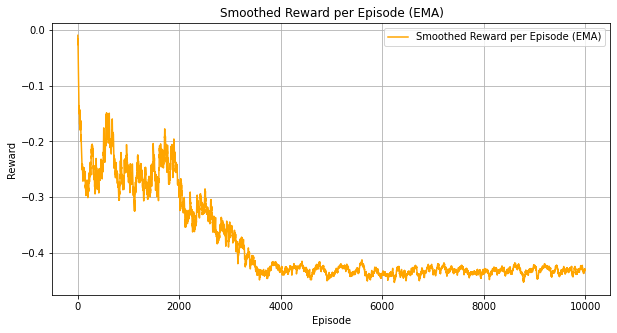

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_list_ema(reward_list, alpha=0.02):
    # Calculate Exponential Moving Average
    ema_rewards = []
    ema = 0
    for reward in reward_list:
        ema = alpha * reward + (1 - alpha) * ema
        ema_rewards.append(ema)
    
    plt.figure(figsize=(10, 5))
    plt.plot(ema_rewards, label='Smoothed Reward per Episode (EMA)', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Smoothed Reward per Episode (EMA)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_reward_list_ema(reward_list)


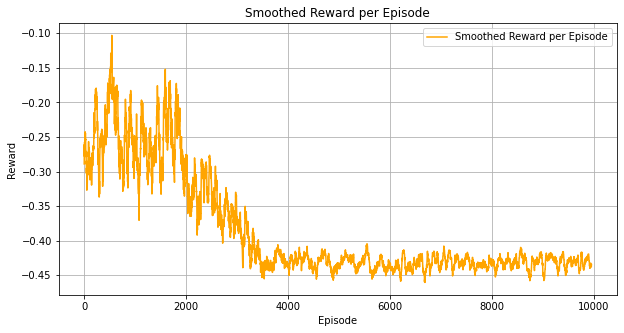

In [88]:
def plot_reward_list(reward_list, window_size=50):
    # Calculate the moving average of rewards
    smoothed_rewards = np.convolve(reward_list, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_rewards, label='Smoothed Reward per Episode', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Smoothed Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_reward_list(reward_list)


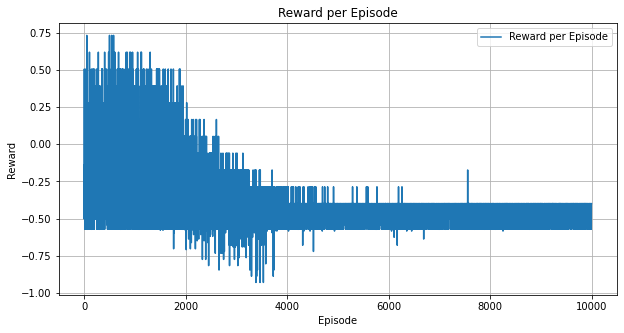

In [93]:
reward_list = [-0.5, -0.42857142857142855, -0.42857142857142855, 0.5059523809523808, -0.3571428571428571, -0.5, -0.13690476190476197, -0.38095238095238093, -0.47023809523809523, -0.22619047619047616, -0.22619047619047628, -0.5714285714285714, -0.3988095238095238, -0.369047619047619, -0.4107142857142857, -0.5714285714285714, -0.22619047619047622, -0.5714285714285714, -0.3988095238095238, -0.13690476190476203, -0.25595238095238093, -0.5714285714285714, -0.5714285714285714, -0.3571428571428571, 0.029761904761904656, -0.5714285714285714, -0.011904761904761973, -0.5714285714285714, 0.3928571428571428, -0.2857142857142857, -0.13690476190476197, -0.25595238095238093, -0.47023809523809523, -0.2857142857142857, -0.5, -0.5714285714285714, 0.2797619047619046, 0.5059523809523808, -0.22619047619047616, -0.18452380952380953, -0.3571428571428571, -0.3214285714285714, 0.5059523809523808, -0.5714285714285714, -0.42857142857142855, -0.3571428571428571, -0.4107142857142857, -0.44047619047619047, -0.2857142857142857, -0.3571428571428571, -0.2857142857142857, 0.732142857142857, -0.3988095238095238, -0.3571428571428571, -0.3571428571428571, -0.2142857142857143, -0.38095238095238093, 0.619047619047619, -0.5714285714285714, -0.42857142857142855, -0.3988095238095238, -0.5, -0.3571428571428571, -0.5714285714285714, -0.25595238095238093, -0.023809523809523947, 0.1666666666666667, -0.4345238095238094, -0.32738095238095233, -0.5714285714285714, -0.5714285714285714, -0.19642857142857145, -0.2976190476190476, -0.33928571428571425, -0.2857142857142857, -0.42857142857142855, -0.3571428571428571, -0.5, -0.32738095238095233, -0.2142857142857143, -0.42857142857142855, -0.5714285714285714, -0.1428571428571429, -0.42857142857142855, -0.38095238095238093, -0.5, 0.2797619047619046, -0.26785714285714285, -0.32738095238095233, -0.22619047619047628, -0.15476190476190482, -0.3630952380952381, -0.32738095238095233, -0.3988095238095238, -0.3571428571428571, -0.2142857142857143, -0.5714285714285714, -0.2857142857142857, -0.5714285714285714, -0.42857142857142855, -0.29761904761904767, -0.5, 0.05952380952380931, -0.2142857142857143, 0.619047619047619, -0.5714285714285714, -0.3988095238095238, -0.2142857142857143, -0.5714285714285714, -0.5714285714285714, 0.3928571428571428, -0.42857142857142855, -0.19642857142857156, -0.1964285714285714, -0.023809523809523836, -0.42857142857142855, -0.19642857142857156, -0.18452380952380953, -0.16666666666666669, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, 0.39285714285714274, -0.07142857142857151, -0.5, -0.023809523809523836, -0.011904761904761973, -0.3571428571428571, -0.42857142857142855, -0.2857142857142857, -0.5714285714285714, -0.13690476190476192, -0.5, -0.011904761904761973, -0.15476190476190477, -0.15476190476190482, -0.3571428571428571, -0.5, -0.369047619047619, -0.19642857142857145, -0.5714285714285714, -0.42857142857142855, 0.5059523809523808, -0.5714285714285714, -0.08333333333333343, -0.5714285714285714, -0.5714285714285714, -0.5, -0.5714285714285714, -0.369047619047619, -0.04166666666666674, -0.5714285714285714, -0.32738095238095233, -0.2142857142857143, -0.3571428571428571, -0.23809523809523814, -0.3988095238095238, -0.5, -0.5714285714285714, -0.3571428571428571, -0.1428571428571429, -0.16666666666666674, -0.3571428571428571, -0.369047619047619, -0.32738095238095233, -0.3571428571428571, 0.5059523809523809, -0.27976190476190477, -0.18452380952380953, -0.3571428571428571, -0.2857142857142857, -0.1250000000000001, -0.22619047619047616, -0.25595238095238093, -0.42857142857142855, -0.2857142857142857, -0.08333333333333343, -0.3571428571428571, -0.5, -0.3988095238095238, -0.2857142857142857, -0.369047619047619, 0.5059523809523809, -0.5, -0.3571428571428571, -0.3571428571428571, -0.19642857142857145, -0.3571428571428571, -0.42261904761904756, -0.25595238095238093, -0.5714285714285714, -0.16666666666666674, -0.5714285714285714, -0.5, -0.42857142857142855, -0.2857142857142857, -0.2857142857142857, -0.5714285714285714, -0.12500000000000006, 0.5059523809523808, -0.2857142857142857, -0.1428571428571429, -0.1964285714285714, -0.47023809523809523, -0.369047619047619, -0.15476190476190488, -0.42857142857142855, -0.26785714285714285, -0.3988095238095238, -0.5, -0.3214285714285714, -0.26785714285714285, -0.2857142857142857, -1.1102230246251565e-16, -0.32738095238095233, -0.47023809523809523, -0.32142857142857134, 0.3928571428571428, -0.3571428571428571, -0.04166666666666674, -0.22619047619047616, -0.2142857142857143, -0.5, 0.2797619047619046, -0.1250000000000001, -0.18452380952380953, -0.09523809523809534, -0.5, -0.47023809523809523, -0.3988095238095238, -0.5, -0.16666666666666685, 0.3928571428571428, -0.5, -0.26785714285714296, -0.255952380952381, -0.3571428571428571, 0.3928571428571427, -0.16666666666666663, -0.5, -0.3571428571428571, -0.11309523809523814, 0.5059523809523807, -0.2976190476190476, -0.15476190476190477, -0.2976190476190476, -0.25595238095238093, -0.5714285714285714, -0.25595238095238093, -0.3571428571428571, -0.2142857142857143, -0.42857142857142855, -0.3392857142857142, -0.42857142857142855, -0.1428571428571429, -0.5714285714285714, 0.3928571428571427, -0.42857142857142855, -0.1250000000000001, 0.27976190476190455, -0.2857142857142857, -0.30952380952380953, -0.0535714285714286, 0.2797619047619046, -0.3571428571428571, -0.22619047619047628, -0.2857142857142857, 0.5059523809523808, -0.13690476190476203, -0.5714285714285714, -0.255952380952381, -0.1428571428571429, 0.3928571428571427, -0.5714285714285714, -0.42857142857142855, -0.3571428571428571, -0.20833333333333343, -0.47023809523809523, -0.1250000000000001, 0.6190476190476188, -0.5, -0.3511904761904763, -0.42857142857142855, -0.04166666666666674, 0.39285714285714274, -0.42857142857142855, -0.5, 0.16666666666666669, -0.25595238095238093, -0.15476190476190477, -0.32738095238095233, -0.2857142857142857, -0.5714285714285714, -0.11309523809523819, -0.2857142857142857, 0.053571428571428624, -0.5714285714285714, -0.2857142857142857, -0.3988095238095238, -0.32738095238095233, 0.3928571428571427, -0.5714285714285714, -0.5714285714285714, -0.3571428571428571, -0.5714285714285714, -0.5714285714285714, -0.44047619047619047, -0.5714285714285714, -0.5, -0.07142857142857151, 0.39285714285714274, -0.5, -0.32738095238095233, 0.05357142857142846, -0.5714285714285714, -0.5, -0.4107142857142857, -0.5416666666666666, -0.22619047619047616, -0.1428571428571429, -0.5714285714285714, -0.3571428571428571, -0.1964285714285714, -0.0952380952380954, -0.25595238095238093, -0.23809523809523814, -0.2142857142857143, -0.5, -0.5, -0.2857142857142857, -0.42857142857142855, -0.369047619047619, -0.5, -0.07142857142857151, -0.47023809523809523, -0.255952380952381, -0.5714285714285714, -0.5714285714285714, -0.13690476190476192, -0.3988095238095238, -0.44047619047619047, -0.07142857142857151, -0.07142857142857151, -0.16666666666666674, -0.5714285714285714, -0.32738095238095233, 0.5059523809523809, -0.3988095238095238, -0.22619047619047616, -0.5714285714285714, -0.29761904761904756, -0.5, 0.5059523809523808, 0.5059523809523809, -0.2142857142857143, -0.2678571428571428, -0.1845238095238096, -0.5, -0.1964285714285714, 0.5059523809523809, 0.27976190476190466, -0.26785714285714296, -0.42857142857142855, -0.42857142857142855, -0.42857142857142855, -0.5714285714285714, -0.11309523809523814, -0.5, -0.5, -0.32738095238095233, 0.27976190476190466, -0.5416666666666666, -0.44047619047619047, -0.22619047619047622, -0.09523809523809523, -0.42857142857142855, -0.369047619047619, -0.42857142857142855, -0.5714285714285714, 0.27976190476190466, -0.15476190476190477, -0.5, -0.32738095238095233, -0.5, -0.5714285714285714, -0.5416666666666666, -0.1428571428571429, -0.5, -0.5714285714285714, 0.05952380952380942, -0.2678571428571429, 0.27976190476190466, -0.3571428571428571, -0.32738095238095233, -0.023809523809523836, -0.5, 0.27976190476190455, -0.5, -0.5, -0.5, -0.42857142857142855, -0.5, -0.19642857142857145, 0.619047619047619, -0.5714285714285714, -0.3571428571428571, -0.42857142857142855, -0.5, -0.5, -0.3988095238095238, -0.5, -0.2976190476190476, -0.2142857142857143, -0.3571428571428571, -0.5, -0.04166666666666674, -0.47023809523809523, 0.10119047619047605, -0.15476190476190477, 0.27976190476190466, 0.5059523809523809, -0.07142857142857151, -0.42261904761904756, -0.5, -0.29761904761904756, 0.27976190476190466, -0.5, -0.1845238095238096, -0.32738095238095233, -0.29761904761904756, -0.42857142857142855, -0.32738095238095233, -0.04166666666666674, -0.3988095238095238, -0.08333333333333337, -0.42857142857142855, -0.3571428571428571, -0.3571428571428571, -0.5, -0.42261904761904756, -0.25595238095238093, 0.5059523809523808, -0.15476190476190477, -0.33928571428571425, -0.11309523809523814, -0.2142857142857143, -0.5416666666666666, -0.18452380952380953, -0.2142857142857143, -0.08333333333333337, -0.5119047619047619, -0.3571428571428571, -0.13690476190476197, -0.22619047619047622, -0.30952380952380953, -0.2142857142857143, 0.3928571428571428, -0.2857142857142857, -0.32738095238095233, 0.39285714285714274, -0.5714285714285714, -0.5, 0.27976190476190477, -0.25595238095238093, -0.5714285714285714, -0.3571428571428571, -0.5, -0.5714285714285714, -0.20833333333333326, 0.27976190476190455, -0.47023809523809523, -0.18452380952380953, -0.5, -0.2857142857142857, -0.5, 0.16666666666666674, -0.5714285714285714, -0.2857142857142857, -0.3571428571428571, -0.42857142857142855, -0.5714285714285714, 0.5059523809523809, 0.6190476190476188, -0.5714285714285714, -0.5714285714285714, -0.255952380952381, -0.5, 0.017857142857142794, -0.5714285714285714, -0.13690476190476197, -0.42857142857142855, 0.1666666666666665, -0.04166666666666674, -0.125, -0.5714285714285714, -0.47023809523809523, -0.2857142857142857, -0.32738095238095233, -0.15476190476190477, 0.732142857142857, -0.5714285714285714, 0.732142857142857, -0.3571428571428571, -0.3809523809523809, -0.11309523809523814, -0.07142857142857151, 0.3928571428571426, 0.3928571428571427, 0.27976190476190455, -0.3571428571428571, 0.3928571428571426, -0.07142857142857151, -0.42857142857142855, -0.42857142857142855, -0.5714285714285714, -0.3571428571428571, -0.29761904761904756, -0.3571428571428571, -0.4107142857142857, -0.5714285714285714, -0.5714285714285714, -0.255952380952381, -0.2857142857142857, -0.3988095238095238, -0.1845238095238096, -0.2857142857142857, -0.2678571428571429, -0.5, -0.29761904761904756, -0.1428571428571429, -0.15476190476190477, -0.5714285714285714, 0.39285714285714274, -0.3571428571428571, -0.3571428571428571, 0.5059523809523808, -0.25595238095238093, -0.32738095238095233, -0.42857142857142855, -0.3571428571428571, -0.2857142857142857, -0.2142857142857143, 0.7321428571428569, -0.5714285714285714, 0.732142857142857, -0.3571428571428571, -0.5, -0.3988095238095238, 0.3928571428571429, -0.42857142857142855, -0.5, 0.5059523809523808, 0.5059523809523809, -0.5, 0.39285714285714274, 0.3928571428571428, -0.3988095238095238, -0.5, 0.2797619047619047, 0.5059523809523808, -0.1428571428571429, -0.47023809523809523, -0.15476190476190482, -0.2857142857142857, -0.09523809523809529, -0.32738095238095233, 0.5059523809523808, -0.1428571428571429, -0.5, -0.47023809523809523, 0.39285714285714274, -0.5714285714285714, -0.5, -0.3571428571428571, -0.5714285714285714, -0.5714285714285714, -0.22619047619047628, -0.47023809523809523, -0.363095238095238, 0.732142857142857, -0.3571428571428571, -0.47023809523809523, -0.42857142857142855, 0.14285714285714268, -0.2857142857142857, -0.2142857142857143, -0.2380952380952382, -0.04166666666666674, 0.3928571428571427, 0.619047619047619, -0.3571428571428571, 0.39285714285714274, -0.4107142857142857, -0.5, -0.32738095238095233, -0.42857142857142855, -0.2857142857142857, -0.3571428571428571, -0.3571428571428571, -0.5714285714285714, -0.3571428571428571, -0.42857142857142855, -0.5, 0.6190476190476188, -0.2857142857142857, -1.1102230246251565e-16, -0.2857142857142857, -0.15476190476190477, -0.0535714285714286, 0.3928571428571426, -0.15476190476190477, -0.20833333333333326, 0.1666666666666667, 0.3928571428571427, -0.23809523809523825, -0.2142857142857143, -0.5, -0.42857142857142855, 0.5059523809523807, -0.5, 0.5059523809523808, -0.5, -0.5714285714285714, -0.25595238095238093, -0.3988095238095238, -0.3392857142857143, -0.25595238095238093, -0.42857142857142855, -0.3571428571428571, -0.15476190476190477, -0.42857142857142855, -0.42857142857142855, -0.45238095238095233, -0.5714285714285714, -0.42857142857142855, 0.39285714285714274, -0.42857142857142855, -0.15476190476190477, -0.5, 0.3928571428571427, -0.5714285714285714, -0.07142857142857151, -0.5, -0.20833333333333343, -0.2857142857142857, -0.3571428571428571, -0.1964285714285714, -0.16666666666666674, 0.39285714285714274, -0.16666666666666663, -0.1845238095238096, -0.08333333333333348, -0.2142857142857143, -0.3571428571428571, -0.3214285714285714, -0.5714285714285714, -0.5, -0.5714285714285714, -0.053571428571428714, -0.42857142857142855, -0.2142857142857143, -0.1428571428571429, 0.5059523809523809, -0.1964285714285714, -0.1845238095238096, -0.42857142857142855, -0.08333333333333337, 0.5059523809523808, -0.29761904761904756, -0.08333333333333348, -0.25595238095238093, -0.16666666666666685, 0.5059523809523808, -0.2142857142857143, -0.5, -0.25595238095238093, -0.07142857142857151, 0.619047619047619, -0.11309523809523814, 0.27976190476190466, -0.5714285714285714, -0.5, -0.38095238095238093, -0.5, -0.5714285714285714, -0.3095238095238095, -0.18452380952380953, 0.3928571428571427, -0.30952380952380953, -0.42857142857142855, -0.1250000000000001, -0.16666666666666669, -0.42857142857142855, -0.42857142857142855, -0.5714285714285714, 0.5059523809523808, -0.3988095238095238, -0.5416666666666666, 0.39285714285714257, -0.5714285714285714, 0.3928571428571429, -0.2857142857142857, -0.3988095238095238, -0.22619047619047628, -0.3988095238095238, -0.42857142857142855, -0.5714285714285714, -0.2857142857142857, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.2142857142857143, -0.3392857142857143, 0.5059523809523809, -0.3571428571428571, 0.27976190476190466, -0.5, -0.5714285714285714, -0.32738095238095233, -0.2976190476190476, -0.5, 0.5059523809523809, -0.25595238095238093, -0.5, -0.3571428571428571, -0.3571428571428571, -0.2857142857142857, -0.5, -0.1428571428571429, -0.2857142857142857, -0.5714285714285714, -0.3392857142857143, -0.5, -0.125, -0.26785714285714285, -0.5, -0.13690476190476203, -0.44047619047619047, -0.3809523809523809, -0.25595238095238093, 0.27976190476190455, -0.25595238095238093, -0.2857142857142857, -0.08333333333333337, -0.42857142857142855, -0.3571428571428571, -0.369047619047619, -0.2857142857142857, 0.5059523809523808, -0.5714285714285714, -0.255952380952381, -0.3571428571428571, 0.5059523809523807, -0.29761904761904767, -0.39285714285714285, -0.44047619047619047, -0.5, -0.5, -0.3571428571428571, -0.08333333333333348, -0.2142857142857143, -0.2142857142857143, -0.5714285714285714, -0.1964285714285715, -0.1964285714285715, -0.5, -0.47023809523809523, 0.39285714285714274, -0.42857142857142855, -0.25595238095238093, -0.3392857142857142, -0.5714285714285714, -0.09523809523809529, -0.1964285714285714, -0.5714285714285714, -0.42857142857142855, -0.5714285714285714, -0.1428571428571429, 0.5059523809523809, -0.3988095238095238, -0.42857142857142855, -0.1666666666666668, -0.5714285714285714, -0.2142857142857143, -0.42857142857142855, -0.3988095238095238, -0.32738095238095233, -0.3571428571428571, -0.29761904761904756, -0.3988095238095238, -0.5, -0.1428571428571429, -0.09523809523809534, -0.15476190476190482, -0.5714285714285714, -0.42857142857142855, -0.15476190476190477, -0.42857142857142855, -0.2857142857142857, -0.42857142857142855, -0.42857142857142855, -0.42857142857142855, -0.5714285714285714, -0.4821428571428571, -0.3571428571428571, -0.3571428571428571, -0.42857142857142855, -0.18452380952380953, -0.25595238095238093, -0.255952380952381, -0.3571428571428571, -0.42857142857142855, -0.25595238095238093, -0.255952380952381, -0.2857142857142857, -0.3988095238095238, -0.2857142857142857, 0.3928571428571426, -0.5, -0.3571428571428571, -0.11309523809523819, -0.42857142857142855, -0.08333333333333337, -0.42857142857142855, -0.2857142857142857, -0.2142857142857143, 0.6190476190476188, -0.5416666666666666, -0.30952380952380953, 0.2797619047619046, 0.1666666666666665, -0.3571428571428571, -0.5, 0.5059523809523809, -0.32738095238095233, 0.3928571428571427, -0.011904761904761973, -0.3988095238095238, -0.47023809523809523, -0.5714285714285714, -0.5, -0.255952380952381, -0.07142857142857151, 0.3928571428571427, -0.42857142857142855, 0.619047619047619, -0.42857142857142855, -0.42857142857142855, 0.3928571428571428, -0.5, -0.3571428571428571, -0.15476190476190477, -0.42857142857142855, -0.1428571428571429, -0.2142857142857143, -0.32738095238095233, -0.5714285714285714, -0.42857142857142855, -0.42857142857142855, -0.42857142857142855, -0.12500000000000006, -0.5, -0.5714285714285714, -0.42857142857142855, -0.33928571428571425, -0.25595238095238093, -0.5, -0.5, -0.5, -0.23809523809523808, 0.5059523809523808, -0.2142857142857143, -0.25595238095238093, -0.42857142857142855, -0.5714285714285714, -0.20833333333333337, -1.1102230246251565e-16, -0.29761904761904767, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.1964285714285714, -0.5714285714285714, -0.3571428571428571, -0.1845238095238096, -0.07142857142857151, -0.5, 0.16666666666666669, -0.32738095238095233, -0.20833333333333337, -0.5714285714285714, -0.07142857142857151, -0.3571428571428571, -0.5, 0.619047619047619, -0.15476190476190482, -0.5, -0.5714285714285714, -0.25, -0.1666666666666668, -0.5714285714285714, -0.42857142857142855, -0.29761904761904756, -0.5714285714285714, -0.1845238095238096, 0.1666666666666667, -0.3571428571428571, 0.5059523809523808, -0.42857142857142855, -0.09523809523809529, -0.053571428571428714, -0.18452380952380953, 0.619047619047619, -0.5, 0.27976190476190477, -0.42857142857142855, -0.47023809523809523, -0.2857142857142857, -0.5, -0.5, -0.04166666666666674, -0.5, -0.42857142857142855, 0.39285714285714274, 0.27976190476190466, -0.18452380952380953, -0.3571428571428571, -0.3571428571428571, -0.2857142857142857, -0.3988095238095238, 0.2797619047619047, -0.3571428571428571, -0.3988095238095238, -0.011904761904761973, -0.2857142857142857, -0.2857142857142857, -0.22619047619047616, -0.2857142857142857, -0.5714285714285714, -0.011904761904761973, -0.19642857142857145, -0.5, -0.42857142857142855, -0.5, -0.5, 0.16666666666666666, -0.5, 0.39285714285714274, -0.25595238095238093, -0.4107142857142857, 0.619047619047619, -0.42857142857142855, 0.029761904761904656, -0.42857142857142855, -0.42857142857142855, -0.22619047619047616, 0.5059523809523809, 0.39285714285714274, -0.2857142857142857, -0.5714285714285714, -0.5, -0.11309523809523819, -0.5714285714285714, -0.11309523809523819, -0.42857142857142855, -0.3988095238095238, -0.3571428571428571, -0.15476190476190482, -0.15476190476190477, -0.5714285714285714, -0.4107142857142857, -0.32738095238095233, -0.5119047619047619, 0.2797619047619046, -0.5, -0.5, -0.5714285714285714, 0.3928571428571429, -0.5, -0.08333333333333337, -0.5, -0.11309523809523819, -0.5714285714285714, -0.5714285714285714, -0.1428571428571429, -0.23809523809523814, 0.2797619047619046, -0.2142857142857143, -0.44047619047619047, -0.5, -0.42857142857142855, -0.42857142857142855, -0.42857142857142855, -0.04166666666666674, -0.42857142857142855, -0.5714285714285714, -0.5, 0.39285714285714274, -0.29761904761904767, -0.09523809523809529, -0.1428571428571429, -0.27976190476190477, 0.27976190476190455, -0.25595238095238093, -0.2857142857142857, -0.22619047619047616, -0.5714285714285714, -0.32738095238095233, -0.38095238095238093, -0.42857142857142855, -0.22619047619047622, -0.42857142857142855, -0.3988095238095238, -0.3988095238095238, -0.33928571428571425, -0.2857142857142857, -0.42857142857142855, -0.42857142857142855, -0.2857142857142857, -0.22619047619047616, -0.5714285714285714, -0.3571428571428571, -0.42857142857142855, -0.47023809523809523, -0.42857142857142855, 0.5059523809523809, -0.3571428571428571, 0.5059523809523809, -0.3571428571428571, -0.3988095238095238, -0.255952380952381, 0.5059523809523809, 0.27976190476190455, -0.42857142857142855, -0.5, -0.42857142857142855, -0.5, -0.255952380952381, -0.2142857142857143, -0.47023809523809523, -0.47023809523809523, -0.47023809523809523, -0.053571428571428714, -0.42857142857142855, -0.22619047619047628, -0.32738095238095233, -0.32738095238095233, -0.07142857142857151, -0.5714285714285714, -0.5416666666666666, 0.619047619047619, -0.2142857142857143, -0.5714285714285714, -0.1428571428571429, -0.3571428571428571, -0.11309523809523814, -0.2857142857142857, -0.053571428571428714, -0.3571428571428571, -0.3571428571428571, -0.42857142857142855, -0.23809523809523808, -0.5, -0.5714285714285714, -0.3571428571428571, 0.5059523809523809, -0.42857142857142855, -0.3928571428571428, 0.1666666666666666, -0.29761904761904756, 0.3928571428571426, -0.023809523809523947, -0.18452380952380953, -0.3571428571428571, -0.5714285714285714, -0.2857142857142857, -0.3571428571428571, -0.18452380952380953, -0.5714285714285714, -0.26785714285714285, -0.5714285714285714, -0.5714285714285714, -0.30952380952380953, -0.5, -0.3214285714285714, -0.2857142857142857, -0.5714285714285714, -0.5714285714285714, -0.5, -0.32738095238095233, -0.3571428571428571, -0.42857142857142855, 0.1666666666666666, -0.07142857142857151, -0.16666666666666674, -0.3571428571428571, -0.3095238095238095, -0.27976190476190477, -0.44047619047619047, -0.47023809523809523, -0.42261904761904756, -0.3571428571428571, -0.42857142857142855, -0.5, -0.3214285714285714, -0.5714285714285714, -0.1964285714285714, -0.42857142857142855, -0.5714285714285714, -0.2857142857142857, -0.5, -0.5, -0.5, -0.42857142857142855, 0.6190476190476188, -0.26785714285714285, -0.47023809523809523, -0.5119047619047619, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.04166666666666674, -0.42857142857142855, -0.16666666666666674, 0.3928571428571426, 0.619047619047619, -0.2500000000000001, -0.42857142857142855, -0.16666666666666674, -0.5714285714285714, -0.1250000000000001, -0.5714285714285714, 0.16666666666666666, 0.27976190476190466, -0.5714285714285714, -0.5, -0.369047619047619, -0.25595238095238093, -0.44047619047619047, -0.12500000000000006, -0.5, -0.2500000000000001, -0.15476190476190482, -0.5714285714285714, 0.27976190476190455, -0.2142857142857143, -0.29761904761904756, 0.39285714285714257, -0.5, -0.023809523809523836, -0.42857142857142855, -0.0535714285714286, -0.5, -0.5, -0.1428571428571429, 0.1666666666666665, -0.19642857142857145, -0.3571428571428571, -0.3571428571428571, -0.2857142857142857, -1.1102230246251565e-16, -0.29761904761904756, -0.04166666666666674, -0.5714285714285714, -0.42857142857142855, 0.5059523809523808, -0.11309523809523814, -0.26785714285714285, -0.5, 0.5059523809523808, -0.5714285714285714, -0.4345238095238094, -0.25595238095238093, -0.2142857142857143, -0.29761904761904756, 0.5059523809523809, 0.1666666666666667, -0.5, -0.07142857142857151, -0.04166666666666674, -0.5714285714285714, -0.47023809523809523, -0.2142857142857143, -0.23809523809523825, -0.3214285714285716, -0.20833333333333343, -0.5, -0.5714285714285714, -0.42857142857142855, -0.5714285714285714, 0.3928571428571428, -0.3571428571428571, 0.3928571428571428, -0.4345238095238094, -0.2857142857142857, -0.29761904761904756, -0.25595238095238093, -0.5119047619047619, -0.3988095238095238, -0.5714285714285714, -0.2857142857142857, -0.42857142857142855, -0.42857142857142855, -0.11309523809523819, -0.42857142857142855, -0.32738095238095233, -0.42857142857142855, -0.3214285714285716, -0.5, 0.3928571428571427, -0.125, -0.26785714285714285, -0.08333333333333337, 0.2797619047619048, -0.5, -0.5714285714285714, -0.47023809523809523, -0.5714285714285714, -0.5, -0.1250000000000001, -0.3571428571428571, -0.26785714285714285, -0.3988095238095238, -0.32738095238095233, 0.3928571428571428, 0.5059523809523809, -0.2678571428571429, -0.5714285714285714, -0.08333333333333337, -0.2857142857142857, -0.369047619047619, -0.18452380952380953, -0.3571428571428571, -0.2857142857142857, 0.017857142857142683, -0.26785714285714285, 0.1666666666666665, -0.38095238095238093, -0.5, -0.25000000000000006, -0.2976190476190476, 0.16666666666666669, -0.42857142857142855, -0.5714285714285714, -0.3571428571428571, -0.4821428571428571, -0.42857142857142855, 0.05357142857142846, -0.5714285714285714, -0.25595238095238093, -0.42857142857142855, -0.32738095238095233, -0.42857142857142855, -0.3571428571428571, -0.09523809523809523, 0.5059523809523809, -0.22619047619047616, -0.42261904761904756, -0.2678571428571429, -0.18452380952380953, -0.5714285714285714, -0.5714285714285714, 0.3928571428571428, -0.5714285714285714, -0.25595238095238093, -0.25595238095238093, -0.47023809523809523, -0.3928571428571428, -0.2678571428571429, -0.1428571428571429, -0.5, -0.3988095238095238, -0.5, -0.42857142857142855, -0.5, 0.1666666666666667, -0.5714285714285714, -0.16666666666666669, -0.32738095238095233, -0.42857142857142855, -0.023809523809523836, -0.3214285714285714, -0.4821428571428571, -0.3571428571428571, -0.1666666666666668, -0.44047619047619047, -0.5, 0.1666666666666667, -0.5, -0.5, -0.23809523809523825, -0.44047619047619047, -0.5, -0.5714285714285714, -0.3988095238095238, -0.2857142857142857, -0.5714285714285714, 0.619047619047619, -0.369047619047619, -0.5714285714285714, 0.1666666666666666, -0.4107142857142857, -0.32738095238095233, -0.3392857142857143, -0.255952380952381, 0.27976190476190466, 0.2797619047619045, -0.2797619047619049, -0.35119047619047616, -0.5714285714285714, -0.25595238095238093, -0.18452380952380953, -0.3214285714285714, -0.2976190476190476, -0.1250000000000001, -0.2142857142857143, 0.39285714285714257, -0.42857142857142855, -0.5, -0.15476190476190482, -0.3988095238095238, -0.2797619047619048, 0.5059523809523808, -0.16666666666666674, -0.18452380952380953, -0.19642857142857145, -0.32738095238095233, -0.42857142857142855, -0.27976190476190477, -0.5714285714285714, -0.2678571428571428, -0.3571428571428571, -0.1964285714285715, 0.3928571428571428, -0.5, -0.39285714285714296, -0.22619047619047616, -0.5, -0.3571428571428571, -0.363095238095238, -0.5, -0.5, -0.42857142857142855, -0.5714285714285714, -0.42857142857142855, 0.2797619047619046, -0.3571428571428571, -0.25595238095238093, -0.5714285714285714, -0.5, -0.1428571428571429, -0.38095238095238093, -0.1428571428571429, -0.3571428571428571, -0.5714285714285714, 0.39285714285714274, -0.2797619047619049, -0.3571428571428571, -0.5, -0.5714285714285714, 0.39285714285714274, -0.42857142857142855, -0.5714285714285714, -0.32738095238095233, -0.5, -0.4107142857142857, -0.5714285714285714, 0.017857142857142794, -0.369047619047619, -0.5, -0.25595238095238093, -0.5714285714285714, -0.4107142857142857, -0.1964285714285715, -0.5, -0.29761904761904756, -0.2142857142857143, -0.3571428571428571, 0.39285714285714285, -0.5714285714285714, -0.3988095238095238, -0.15476190476190477, 0.39285714285714274, -0.07142857142857151, -0.3988095238095238, -0.5, -0.5, 0.27976190476190477, -0.25000000000000006, -0.32738095238095233, -0.2857142857142857, 0.16666666666666669, -0.47023809523809523, -0.3988095238095238, -0.16666666666666674, -0.5714285714285714, -0.38095238095238093, -0.08333333333333337, -0.42857142857142855, -0.23809523809523825, 0.3928571428571426, -0.5714285714285714, 0.1666666666666666, -0.5, -0.2857142857142857, -0.44047619047619047, -0.4345238095238094, -0.09523809523809534, -0.5, -0.3571428571428571, -0.5714285714285714, -0.1428571428571429, -0.32738095238095233, -0.2142857142857143, -0.3571428571428571, -0.5, -0.5416666666666666, -0.5, -0.1845238095238096, -0.2142857142857143, -0.3214285714285715, -0.3988095238095238, -0.5714285714285714, -0.15476190476190477, -0.42857142857142855, 0.5059523809523808, -0.3571428571428571, -0.5, -0.1250000000000001, -0.3571428571428571, -0.5714285714285714, 0.5059523809523809, -0.5714285714285714, 0.27976190476190466, -0.23809523809523803, 0.3928571428571427, -0.29761904761904756, -0.5714285714285714, 0.5059523809523809, -0.25595238095238093, -0.18452380952380953, -0.5, 0.27976190476190477, -0.4821428571428571, -0.47023809523809523, -0.3571428571428571, -0.4821428571428571, -0.26785714285714285, -0.42857142857142855, -0.5714285714285714, -0.18452380952380953, -0.42857142857142855, -0.5714285714285714, -0.5119047619047619, -0.1964285714285715, 0.5059523809523808, -0.2142857142857143, -0.42857142857142855, 0.39285714285714274, -0.5, -0.3571428571428571, -0.369047619047619, -0.22619047619047622, -0.22619047619047616, -0.3571428571428571, 0.16666666666666669, 0.39285714285714285, -0.5, -0.32738095238095233, -0.3988095238095238, -0.42857142857142855, 0.5059523809523808, -0.2857142857142857, -0.42857142857142855, -0.42857142857142855, -0.5714285714285714, 0.2797619047619049, -0.33928571428571425, 0.16666666666666669, -0.3392857142857143, 0.5059523809523809, 0.16666666666666669, 0.3928571428571427, -0.25595238095238093, -0.363095238095238, -0.2797619047619047, -0.4642857142857142, -0.5, -0.2500000000000001, -0.3214285714285714, -0.16666666666666674, -0.29761904761904756, -0.369047619047619, -0.5, -0.3571428571428571, 0.27976190476190477, -0.5714285714285714, -0.3571428571428571, -0.5773809523809523, -0.5714285714285714, -0.42261904761904756, 0.16666666666666669, -0.11309523809523814, -0.25595238095238093, 0.16666666666666666, -0.3988095238095238, 0.053571428571428624, -0.255952380952381, -0.3988095238095238, -0.5, -0.5714285714285714, -0.4345238095238094, -0.5714285714285714, -0.2142857142857143, -0.42857142857142855, -0.5714285714285714, -0.42857142857142855, 0.39285714285714274, -0.47023809523809523, -0.47023809523809523, -0.3571428571428571, -0.5714285714285714, 0.27976190476190466, -0.42261904761904756, 0.16666666666666669, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5476190476190476, -0.42857142857142855, -0.5714285714285714, 0.27976190476190466, -0.2857142857142857, -0.25595238095238093, 0.05357142857142857, -0.5, -0.3928571428571428, -0.20833333333333337, -0.45238095238095233, -0.44047619047619047, 0.2797619047619046, -0.369047619047619, 0.27976190476190466, -0.15476190476190488, -0.5714285714285714, -0.3928571428571429, -0.5714285714285714, -0.4821428571428571, -0.5714285714285714, 0.05357142857142859, -0.5773809523809523, -0.5, -0.42857142857142855, -0.4821428571428571, -0.5119047619047619, -0.04166666666666674, 0.5059523809523808, -0.3988095238095238, -0.3095238095238095, -0.26785714285714285, -0.3214285714285714, 0.3928571428571427, -0.47023809523809523, 0.16666666666666666, -0.39285714285714285, -0.47023809523809523, -0.5, -0.4107142857142857, -0.5, -0.5714285714285714, -0.22619047619047616, -0.5357142857142857, 0.16666666666666669, -0.5714285714285714, 0.017857142857142794, -0.47023809523809523, -0.5, -0.3392857142857143, -0.32738095238095233, -0.5714285714285714, -0.33928571428571425, 0.053571428571428624, -0.3392857142857143, -0.5, -0.42857142857142855, -0.20833333333333343, -0.5, -0.5654761904761905, 0.3928571428571427, -0.5714285714285714, -0.0952380952380954, 0.3928571428571427, 0.3928571428571428, -0.47023809523809523, -0.42857142857142855, 0.5059523809523809, 0.2797619047619047, -0.42857142857142855, -0.2857142857142857, -0.1428571428571429, -0.22619047619047616, 0.3928571428571428, 0.39285714285714274, -0.44047619047619047, -0.30952380952380965, 0.39285714285714257, -0.5714285714285714, 0.3928571428571427, -0.5, 0.27976190476190466, -0.5714285714285714, -0.5714285714285714, 0.05357142857142857, -0.1964285714285714, -0.5, -0.4345238095238094, 0.39285714285714274, -0.255952380952381, -0.5714285714285714, -0.42857142857142855, 0.05357142857142865, -0.5, -0.42857142857142855, 0.27976190476190466, -0.5, 0.16666666666666669, -0.42857142857142855, -0.3571428571428571, 0.16666666666666666, 0.39285714285714274, -0.42261904761904756, -0.2678571428571429, -0.42857142857142855, -0.5714285714285714, -0.1964285714285714, -0.1845238095238096, -0.45238095238095233, -0.18452380952380953, -0.3214285714285714, -0.44047619047619047, -0.3988095238095238, -0.5714285714285714, -0.5, 0.3928571428571427, 0.16666666666666669, -0.47023809523809523, -0.3095238095238095, 0.16666666666666669, 0.27976190476190466, -0.5, -0.5714285714285714, -0.42857142857142855, -0.5714285714285714, -0.33928571428571425, 0.5059523809523809, -0.33928571428571425, -0.5714285714285714, -0.1250000000000001, -0.47023809523809523, -0.5, 0.27976190476190455, -0.3988095238095238, -0.3571428571428571, -0.3095238095238096, -0.125, -0.3988095238095238, -0.42857142857142855, 0.2797619047619046, 0.27976190476190466, -0.3988095238095238, 0.27976190476190466, -0.2142857142857143, -0.5714285714285714, -0.5059523809523809, -0.5, -0.5714285714285714, 0.16666666666666669, -0.5714285714285714, -0.25595238095238093, -0.5, -0.1428571428571429, -0.42857142857142855, 0.05357142857142857, -0.2678571428571429, -0.5714285714285714, 0.13095238095238082, 0.1666666666666666, -0.42857142857142855, -0.5, -0.1964285714285715, 0.27976190476190477, 0.27976190476190455, -0.29761904761904756, -0.369047619047619, -0.3571428571428571, -0.5357142857142857, -0.1428571428571429, -0.11309523809523814, 0.1666666666666666, -0.3095238095238095, -0.3571428571428571, 0.1666666666666666, -0.2797619047619048, 0.39285714285714257, 0.053571428571428624, 0.27976190476190477, -0.18452380952380953, -0.27976190476190493, 0.5059523809523807, -0.44047619047619047, 0.16666666666666674, -0.5, -0.42857142857142855, -0.5238095238095237, -0.5714285714285714, -0.18452380952380953, 0.27976190476190466, -0.5416666666666666, 0.16666666666666663, -0.5, -0.5, -0.25000000000000006, 0.1666666666666666, 0.16666666666666663, -0.5714285714285714, -0.5, -0.38095238095238093, -0.5, -0.29761904761904756, -0.2857142857142857, 0.053571428571428624, -0.5714285714285714, 0.053571428571428624, -0.17261904761904756, 0.1666666666666667, -0.4642857142857142, -0.5, -0.5, -0.369047619047619, 0.05357142857142846, -0.5, -0.5714285714285714, -0.3214285714285715, -0.42857142857142855, 0.27976190476190455, -0.5, -0.5, -0.3988095238095238, -0.42857142857142855, -0.47023809523809523, -0.35119047619047616, 0.053571428571428596, -0.5714285714285714, -0.42857142857142855, 0.3928571428571428, 0.5059523809523809, 0.2797619047619048, 0.27976190476190466, -0.3988095238095238, -0.49404761904761896, -0.7023809523809523, 0.16666666666666669, -0.18452380952380953, -0.42857142857142855, 0.27976190476190466, 0.053571428571428624, -0.5714285714285714, -0.059523809523809444, -0.5, -0.5, -0.3095238095238094, -0.5357142857142857, -0.5952380952380952, 0.1666666666666667, -0.3988095238095238, -0.5119047619047619, -0.3571428571428571, -0.5714285714285714, 0.16666666666666669, -0.5714285714285714, -0.3809523809523809, -0.5714285714285714, -0.3809523809523809, -0.369047619047619, -0.5714285714285714, -0.3988095238095238, -0.42857142857142855, -0.18452380952380953, -0.5714285714285714, -0.059523809523809444, -0.5, 0.27976190476190466, -0.059523809523809486, -0.3571428571428571, -0.5, 0.1666666666666667, -0.42261904761904756, -0.5714285714285714, -0.5714285714285714, -0.32738095238095233, 0.053571428571428624, -0.5, -0.2142857142857143, -0.44047619047619047, -0.26785714285714285, 0.1666666666666666, -0.369047619047619, 0.053571428571428624, 0.16666666666666655, -0.369047619047619, -0.35119047619047616, -0.44047619047619047, -0.2678571428571428, -0.2976190476190476, -0.4107142857142857, -0.35119047619047616, -0.2857142857142857, -0.3571428571428571, -0.23809523809523814, 0.1666666666666666, 0.27976190476190477, 0.27976190476190477, -0.5714285714285714, -0.5416666666666666, -0.1428571428571429, 0.053571428571428596, 0.16666666666666669, -0.42857142857142855, 0.16666666666666666, -0.05952380952380947, 0.3928571428571428, 0.053571428571428596, -0.5714285714285714, -0.42857142857142855, -0.3988095238095238, -0.5, 0.053571428571428596, 0.1666666666666667, -0.3988095238095238, -0.5714285714285714, -0.44047619047619047, 0.16666666666666666, 0.053571428571428624, 0.27976190476190455, -0.42857142857142855, -0.25595238095238093, -0.32738095238095233, -0.35119047619047616, -0.5714285714285714, 0.2797619047619047, -0.5, 0.16666666666666669, 0.16666666666666655, -0.4107142857142857, -0.42857142857142855, -0.35119047619047616, -0.059523809523809486, -0.059523809523809486, -0.2857142857142857, -0.3988095238095238, -0.5, -0.5, -0.11309523809523819, -0.44047619047619047, -0.42857142857142855, -0.44047619047619047, -0.5, -0.5714285714285714, -0.3988095238095238, -0.5, -0.5476190476190476, -0.3571428571428571, 0.16666666666666674, 0.053571428571428624, 0.5059523809523809, 0.16666666666666666, -0.15476190476190477, -0.5714285714285714, -0.369047619047619, 0.16666666666666655, 0.16666666666666655, 0.1666666666666666, -0.2857142857142857, -0.2857142857142857, -0.3095238095238096, -0.15476190476190488, 0.16666666666666666, -0.5, -0.42857142857142855, 0.5059523809523809, 0.1666666666666667, -0.47023809523809523, -0.17261904761904756, -0.3392857142857142, -0.42261904761904756, 0.05357142857142857, -0.32738095238095233, -0.25595238095238093, -0.4642857142857142, -0.42857142857142855, -0.32738095238095233, -0.5714285714285714, -0.5238095238095237, -0.30952380952380953, -0.45238095238095233, 0.3928571428571428, -0.1726190476190476, -0.5714285714285714, 0.053571428571428596, 0.053571428571428624, -0.4345238095238094, -0.5654761904761905, -0.4761904761904763, 0.1666666666666667, -0.5416666666666666, -0.5714285714285714, -0.5, -0.3571428571428571, -0.369047619047619, -0.2857142857142857, -0.44047619047619047, 0.053571428571428624, -0.46428571428571425, -0.2857142857142857, 0.2797619047619047, -0.5059523809523809, -0.05952380952380947, -0.5, -0.32738095238095233, -0.5, 0.27976190476190466, 0.05357142857142868, -0.49404761904761896, -0.5, -0.5, 0.05357142857142857, 0.27976190476190466, -0.42857142857142855, -0.11309523809523814, -0.5714285714285714, -0.5714285714285714, 0.16666666666666669, -0.5238095238095237, -0.5, 0.39285714285714274, -0.32738095238095233, -0.5714285714285714, 0.16666666666666669, -0.42857142857142855, -0.18452380952380953, -0.11309523809523819, -0.4107142857142857, -0.32738095238095233, -0.42857142857142855, 0.05357142857142854, -0.5714285714285714, -0.3571428571428571, -0.32738095238095233, -0.49404761904761896, -0.5, -0.5476190476190476, -0.35119047619047616, -0.2857142857142857, -0.5714285714285714, -0.2857142857142857, 0.053571428571428596, -0.17261904761904756, -0.5714285714285714, 0.05357142857142857, -0.5, -0.49404761904761896, -0.17261904761904756, 0.0535714285714286, -0.3988095238095238, -0.4642857142857142, 0.053571428571428596, -0.4821428571428571, -0.33928571428571425, -0.2797619047619049, -0.5119047619047619, -0.05952380952380947, -0.3988095238095238, -0.05952380952380951, -0.0595238095238095, -0.5714285714285714, -0.0595238095238095, -0.47023809523809523, -0.5, -0.5, -0.1726190476190476, -0.5, -0.5773809523809523, -0.42857142857142855, -0.42261904761904756, -0.5, 0.16666666666666669, 0.16666666666666674, -0.0595238095238095, -0.5, -0.5, -0.0595238095238095, -0.44047619047619047, -0.5714285714285714, -0.5476190476190476, 0.16666666666666655, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.7083333333333333, -0.6071428571428571, -0.3571428571428571, -0.47023809523809523, -0.5714285714285714, -0.05952380952380948, 0.16666666666666669, 0.053571428571428596, -0.4642857142857143, 0.2797619047619045, -0.3571428571428571, 0.053571428571428624, -0.1726190476190476, -0.059523809523809486, 0.053571428571428624, -0.4642857142857142, -0.255952380952381, 0.05357142857142857, -0.1726190476190476, -0.1726190476190476, -0.5119047619047619, -0.5714285714285714, -0.059523809523809514, -0.05952380952380947, -0.5714285714285714, -0.3392857142857142, -0.47023809523809523, -0.5714285714285714, -0.0595238095238095, 0.053571428571428596, -0.25595238095238093, -0.5714285714285714, -0.5, 0.05357142857142857, -0.5, -0.5, -0.4821428571428571, -0.5654761904761905, 0.1666666666666666, -0.46428571428571425, -0.32738095238095233, -0.47619047619047616, -0.5714285714285714, -0.47023809523809523, -0.5, -0.30952380952380953, -0.5714285714285714, -0.1726190476190476, -0.6369047619047619, -0.17261904761904756, -0.42857142857142855, -0.5714285714285714, -0.059523809523809486, -0.059523809523809514, -0.1726190476190476, -0.5714285714285714, -0.5119047619047619, -0.2857142857142857, -0.5714285714285714, -0.059523809523809514, -0.17261904761904756, -0.5714285714285714, -0.0595238095238095, -0.3988095238095238, -0.32738095238095233, -0.42857142857142855, -0.5, -0.47023809523809523, -0.255952380952381, -0.5714285714285714, 0.05357142857142868, -0.5714285714285714, 0.053571428571428624, -0.5714285714285714, -0.42261904761904767, -0.05952380952380947, -0.5, 0.05357142857142868, -0.3988095238095238, -0.0595238095238095, -0.44047619047619047, 0.05357142857142857, -0.7023809523809523, -0.059523809523809486, -0.35119047619047616, -0.5, 0.05357142857142857, 0.053571428571428624, -0.5714285714285714, -0.4761904761904761, -0.5773809523809523, -0.0595238095238095, -0.5, -0.5714285714285714, -0.5714285714285714, -0.17261904761904756, -0.3988095238095238, -0.5714285714285714, -0.5, -0.42857142857142855, -0.6607142857142857, -0.6607142857142857, -0.5, 0.053571428571428624, -0.5119047619047619, -0.4821428571428571, -0.4761904761904761, -0.5714285714285714, 0.1666666666666667, -0.5119047619047619, -0.5, -0.3392857142857143, -0.5714285714285714, -0.3511904761904763, -0.17261904761904756, -0.47023809523809523, 0.053571428571428624, -0.5714285714285714, -0.5238095238095237, -0.17261904761904756, -0.1726190476190476, -0.5476190476190476, -0.17261904761904756, 0.053571428571428624, -0.49404761904761896, 0.05357142857142865, -0.0595238095238095, -0.1726190476190476, -0.42857142857142855, -0.1726190476190476, -0.5714285714285714, -0.5, -0.3392857142857143, -0.3571428571428571, -0.49404761904761896, -0.5714285714285714, -0.0595238095238095, 0.05357142857142865, -0.5773809523809523, -0.5714285714285714, 0.1666666666666666, -0.5, -0.42857142857142855, -0.05952380952380947, -0.45238095238095233, -0.3571428571428571, -0.6071428571428571, -0.49404761904761896, -0.47023809523809523, -0.4821428571428571, -0.5, -0.2857142857142857, -0.05952380952380947, -0.47023809523809523, -0.0595238095238095, -0.42857142857142855, -0.5, -0.17261904761904756, -0.44047619047619047, -0.17261904761904756, 0.05357142857142857, -0.5714285714285714, -0.5, -0.5714285714285714, -0.17261904761904756, 0.053571428571428596, 0.053571428571428645, -0.5416666666666666, -0.17261904761904756, -0.5, -0.3988095238095238, -0.47023809523809523, -0.42857142857142855, -0.5714285714285714, -0.17261904761904756, -0.059523809523809444, -0.4761904761904761, -0.05952380952380947, -0.5714285714285714, -0.059523809523809486, -0.5, -0.7023809523809523, 0.05357142857142865, -0.369047619047619, -0.5, -0.4345238095238094, 0.16666666666666669, -0.5, -0.17261904761904756, -0.369047619047619, -0.369047619047619, -0.5, -0.059523809523809444, -0.1726190476190476, -0.5416666666666666, -0.17261904761904756, -0.5714285714285714, -0.0595238095238095, -0.05952380952380947, -0.0595238095238095, 0.053571428571428624, -0.4821428571428571, 0.053571428571428596, 0.16666666666666669, -0.1726190476190476, -0.47023809523809523, -0.4821428571428571, -0.5714285714285714, -0.369047619047619, -0.17261904761904756, -0.625, -0.47023809523809523, -0.17261904761904756, -0.3988095238095238, -0.5, -0.17261904761904756, -0.6488095238095237, -0.5476190476190476, -0.17261904761904756, -0.5654761904761905, -0.5714285714285714, -0.3988095238095238, -0.05952380952380947, -0.1726190476190476, -0.17261904761904756, -0.17261904761904756, -0.5, -0.5357142857142857, -0.17261904761904756, -0.3988095238095238, -0.5714285714285714, -0.5714285714285714, -0.05952380952380947, -0.05952380952380947, -0.5714285714285714, -0.059523809523809444, -0.49404761904761896, -0.6071428571428571, -0.42857142857142855, -0.5773809523809523, -0.3988095238095238, -0.44047619047619047, -0.5, -0.45238095238095233, -0.5714285714285714, -0.17261904761904756, -0.6369047619047619, -0.17261904761904756, -0.5119047619047619, -0.42857142857142855, -0.5, -0.5714285714285714, -0.3988095238095238, -0.17261904761904756, -0.1726190476190476, -0.28571428571428564, -0.1726190476190476, -0.5, -0.5714285714285714, -0.17261904761904756, 0.16666666666666669, -0.5, -0.17261904761904756, -0.42857142857142855, -0.5238095238095237, -0.059523809523809444, -0.0595238095238095, -0.42857142857142855, -0.05952380952380947, -0.5, 0.1666666666666667, -0.5119047619047619, -0.17261904761904756, -0.5, -0.44047619047619047, -0.17261904761904756, -0.42857142857142855, -0.5714285714285714, -0.059523809523809486, -0.5714285714285714, -0.5714285714285714, -0.47023809523809523, -0.5, -0.5, -0.47023809523809523, -0.5, -0.6071428571428571, -0.3988095238095238, -0.44047619047619047, -0.17261904761904762, 0.05357142857142859, -0.3988095238095238, -0.05952380952380947, -0.5535714285714285, -0.5119047619047619, -0.5714285714285714, -0.17261904761904756, -0.1726190476190476, -0.3988095238095238, -0.059523809523809486, -0.5, -0.4107142857142857, -0.5238095238095237, -0.5714285714285714, -0.1726190476190476, -0.5, -0.17261904761904756, -0.05952380952380947, -0.05952380952380947, -0.42857142857142855, -0.28571428571428564, -0.2857142857142857, -0.42857142857142855, -0.17261904761904756, -0.059523809523809514, -0.5714285714285714, -0.17261904761904756, -0.5714285714285714, -0.28571428571428564, -0.7738095238095237, -0.17261904761904756, -0.5, -0.5714285714285714, -0.0595238095238095, -0.5357142857142857, -0.05952380952380947, -0.42857142857142855, -0.05952380952380947, 0.053571428571428596, -0.17261904761904756, -0.42857142857142855, -0.1726190476190476, 0.053571428571428624, -0.1726190476190476, -0.0595238095238095, -0.5, -0.17261904761904756, -0.05952380952380947, -0.05952380952380947, -0.5, -0.1726190476190476, -0.0595238095238095, -0.17261904761904756, -0.5714285714285714, -0.5714285714285714, -0.1726190476190476, -0.1726190476190476, -0.5892857142857142, -0.5714285714285714, -0.5, -0.5714285714285714, -0.5238095238095238, 0.16666666666666669, -0.6488095238095237, -0.05952380952380947, -0.17261904761904756, -0.28571428571428564, 0.05357142857142859, -0.4821428571428571, -0.5, -0.5714285714285714, -0.5, -0.5476190476190476, -0.28571428571428564, -0.059523809523809514, -0.2857142857142857, -0.47023809523809523, -0.5416666666666666, -0.1726190476190476, -0.44047619047619047, 0.053571428571428624, -0.5714285714285714, -0.17261904761904762, -0.42857142857142855, -0.47023809523809523, -0.17261904761904756, -0.5476190476190476, -0.17261904761904756, -0.5714285714285714, -0.17261904761904756, -0.5535714285714285, -0.47023809523809523, 0.053571428571428596, 0.05357142857142868, -0.7738095238095237, -0.5714285714285714, -0.5773809523809523, -0.17261904761904756, -0.0595238095238095, -0.369047619047619, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.42857142857142855, -0.17261904761904756, -0.059523809523809486, -0.0595238095238095, -0.42857142857142855, -0.0595238095238095, 0.053571428571428645, -0.369047619047619, -0.2976190476190476, -0.059523809523809486, -0.5773809523809523, -0.2857142857142857, -0.1726190476190476, -0.0595238095238095, -0.5, -0.17261904761904756, -0.5535714285714285, -0.28571428571428564, -0.42857142857142855, -0.5833333333333333, -0.5714285714285714, -0.17261904761904756, -0.17261904761904756, -0.1726190476190476, -0.28571428571428564, -0.17261904761904756, -0.3571428571428571, -0.1726190476190476, -0.17261904761904756, -0.42857142857142855, -0.44047619047619047, -0.5416666666666666, -0.1726190476190476, -0.6607142857142857, -0.17261904761904756, -0.5714285714285714, -0.28571428571428564, -0.1726190476190476, -0.17261904761904756, -0.5714285714285714, -0.1726190476190476, -0.5714285714285714, -0.5714285714285714, -0.17261904761904756, -0.5119047619047619, -0.17261904761904756, -0.5119047619047619, -0.1726190476190476, -0.17261904761904756, -0.8154761904761904, -0.5119047619047619, -0.17261904761904756, -0.47023809523809523, -0.1726190476190476, -0.17261904761904756, -0.5, -0.059523809523809514, -0.05952380952380947, -0.05952380952380947, -0.44047619047619047, -0.1726190476190476, -0.5714285714285714, -0.5714285714285714, -0.5, -0.2857142857142857, -0.17261904761904756, -0.1726190476190476, -0.42857142857142855, -0.17261904761904756, -0.5416666666666666, -0.5714285714285714, -0.42857142857142855, -0.05952380952380947, -0.1726190476190476, -0.5714285714285714, -0.5, -0.05952380952380948, -0.17261904761904756, -0.28571428571428564, -0.619047619047619, -0.1726190476190476, -0.5, -0.42857142857142855, -0.059523809523809444, -0.17261904761904756, -0.6071428571428571, -0.28571428571428564, -0.17261904761904756, -0.1726190476190476, -0.059523809523809444, -0.2857142857142857, -0.17261904761904756, -0.17261904761904756, -0.05952380952380947, -0.5119047619047619, -0.059523809523809486, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.1726190476190476, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.17261904761904756, -0.17261904761904756, -0.5, -0.5714285714285714, -0.5, -0.059523809523809486, -0.1726190476190476, -0.17261904761904756, -0.2857142857142857, -0.5, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.1726190476190476, -0.1726190476190476, -0.5238095238095237, -0.42857142857142855, -0.47023809523809523, -0.5714285714285714, -0.059523809523809444, -0.44047619047619047, -0.44047619047619047, -0.17261904761904756, -0.5416666666666666, -0.1726190476190476, -0.6071428571428571, -0.619047619047619, -0.17261904761904756, -0.17261904761904756, -0.47023809523809523, -0.42857142857142855, -0.1726190476190476, -0.42857142857142855, -0.5714285714285714, 0.053571428571428624, -0.39880952380952384, -0.17261904761904756, -0.28571428571428564, -0.4821428571428571, -0.17261904761904756, -0.17261904761904756, -0.5654761904761905, -0.5714285714285714, -0.059523809523809444, -0.17261904761904756, -0.5654761904761905, -0.4107142857142857, -0.05952380952380947, -0.5714285714285714, -0.28571428571428564, -0.5, -0.059523809523809486, -0.0595238095238095, -0.42857142857142855, -0.5, -0.5714285714285714, -0.1726190476190476, -0.5416666666666666, -0.5714285714285714, -0.1726190476190476, -0.5, -0.17261904761904756, -0.5, -0.5833333333333333, -0.47023809523809523, -0.17261904761904756, -0.5714285714285714, -0.1726190476190476, -0.1726190476190476, -0.5714285714285714, -0.059523809523809444, -0.17261904761904756, -0.7023809523809523, -0.2857142857142857, 0.053571428571428575, -0.059523809523809486, -0.42857142857142855, -0.7321428571428571, -0.0595238095238095, -0.5714285714285714, -0.059523809523809486, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.42857142857142855, -0.5, -0.42261904761904756, -0.5714285714285714, -0.5, -0.5714285714285714, -0.1726190476190476, -0.17261904761904756, -0.5, -0.5714285714285714, -0.42857142857142855, -0.17261904761904756, -0.5416666666666666, -0.28571428571428564, 0.16666666666666669, -0.1726190476190476, -0.5, -0.5, -0.17261904761904756, -0.1726190476190476, -0.05952380952380947, -0.17261904761904756, -0.44047619047619047, -0.17261904761904756, -0.17261904761904756, 0.053571428571428624, -0.1726190476190476, -0.28571428571428564, -0.05952380952380947, -0.5714285714285714, -0.1726190476190476, -0.1726190476190476, -0.2857142857142857, -0.5714285714285714, -0.44047619047619047, -0.5714285714285714, -0.5714285714285714, -0.17261904761904756, -0.17261904761904756, -0.1726190476190476, -0.5714285714285714, -0.42857142857142855, -0.3988095238095238, -0.17261904761904756, -0.1726190476190476, -0.5416666666666666, -0.44047619047619047, -0.17261904761904756, -0.17261904761904756, -0.5416666666666666, -0.5714285714285714, -0.5, -0.4821428571428571, -0.5714285714285714, -0.1726190476190476, -0.5714285714285714, 0.05357142857142854, -0.1726190476190476, -0.5714285714285714, -0.5714285714285714, -0.17261904761904756, -0.5714285714285714, -0.6666666666666666, -0.2857142857142857, -0.5, -0.5, -0.8452380952380951, -0.28571428571428564, -0.5119047619047619, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.5714285714285714, -0.44047619047619047, -0.28571428571428564, -0.17261904761904756, -0.2857142857142857, -0.5357142857142857, -0.1726190476190476, -0.5416666666666666, -0.28571428571428564, -0.17261904761904756, -0.28571428571428564, -0.5, -0.28571428571428564, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.5714285714285714, -0.5714285714285714, -0.28571428571428564, -0.17261904761904756, -0.5714285714285714, -0.1726190476190476, -0.3988095238095238, -0.42857142857142855, -0.5952380952380952, -0.5119047619047619, -0.5714285714285714, -0.7321428571428571, -0.2857142857142857, -0.2857142857142857, -0.0595238095238095, -0.17261904761904756, -0.2857142857142857, -0.28571428571428564, -0.17261904761904756, -0.44047619047619047, -0.1726190476190476, -0.5714285714285714, -0.28571428571428564, -0.3988095238095238, -0.5714285714285714, -0.5, -0.17261904761904762, -0.42857142857142855, -0.17261904761904756, -0.17261904761904756, -0.2857142857142857, -0.17261904761904756, -0.2857142857142857, -0.17261904761904756, -0.5714285714285714, -0.7321428571428571, -0.5714285714285714, -0.44047619047619047, -0.7202380952380951, -0.5654761904761905, -0.1726190476190476, -0.17261904761904756, -0.5, -0.2857142857142857, -0.5714285714285714, -0.1726190476190476, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.5238095238095237, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.0595238095238095, -0.42857142857142855, -0.28571428571428564, -0.5714285714285714, -0.17261904761904756, -0.45238095238095233, -0.28571428571428564, -0.6488095238095237, -0.47023809523809523, -0.2857142857142857, -0.6369047619047619, -0.5714285714285714, -0.2857142857142857, -0.7738095238095237, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.5714285714285714, -0.1726190476190476, -0.28571428571428564, -0.2857142857142857, -0.1726190476190476, -0.28571428571428564, -0.5, -0.5714285714285714, -0.1726190476190476, -0.2857142857142857, -0.5535714285714285, -0.7202380952380951, -0.28571428571428564, -0.47023809523809523, -0.5416666666666666, -0.5714285714285714, -0.17261904761904756, -0.1726190476190476, -0.17261904761904756, -0.5, -0.28571428571428564, -0.2857142857142857, -0.42857142857142855, -0.5714285714285714, -0.5714285714285714, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.47023809523809523, -0.5714285714285714, -0.3988095238095238, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.5952380952380952, -0.2857142857142857, -0.5714285714285714, -0.17261904761904756, -0.5714285714285714, -0.1726190476190476, -0.5714285714285714, -0.2857142857142857, -0.4821428571428571, -0.1726190476190476, -0.17261904761904756, -0.059523809523809444, -0.44047619047619047, -0.2857142857142857, -0.1726190476190476, -0.5714285714285714, -0.2857142857142857, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.42857142857142855, -0.2857142857142857, -0.05952380952380947, -0.2857142857142857, -0.1726190476190476, -0.44047619047619047, -0.5, -0.1726190476190476, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.5714285714285714, -0.4821428571428571, -0.1726190476190476, -0.1726190476190476, -0.5714285714285714, -0.17261904761904756, -0.44047619047619047, -0.17261904761904756, -0.17261904761904756, -0.28571428571428564, -0.059523809523809514, -0.1726190476190476, -0.5, -0.39880952380952384, -0.17261904761904756, -0.5, -0.5714285714285714, -0.5, -0.5535714285714285, -0.42857142857142855, -0.5, -0.1726190476190476, -0.5714285714285714, -0.5, -0.28571428571428564, -0.2857142857142857, -0.1726190476190476, -0.1726190476190476, -0.44047619047619047, -0.0595238095238095, -0.17261904761904756, -0.5952380952380952, -0.17261904761904756, -0.5952380952380952, -0.28571428571428564, -0.17261904761904756, -0.2857142857142857, -0.28571428571428564, -0.5238095238095237, -0.28571428571428564, -0.5, -0.5714285714285714, -0.17261904761904756, -0.6785714285714285, -0.17261904761904756, -0.059523809523809486, -0.5714285714285714, -0.28571428571428564, -0.8154761904761905, -0.28571428571428564, -0.2857142857142857, -0.5119047619047619, -0.5714285714285714, -0.17261904761904756, -0.5, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.1726190476190476, -0.17261904761904762, -0.6071428571428571, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.1726190476190476, -0.47023809523809523, -0.5773809523809523, -0.6785714285714285, -0.28571428571428564, -0.42857142857142855, -0.4821428571428571, -0.17261904761904756, -0.5119047619047619, -0.28571428571428564, -0.28571428571428564, -0.5, -0.2857142857142857, -0.5714285714285714, -0.17261904761904756, -0.5714285714285714, -0.42857142857142855, -0.17261904761904756, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.5714285714285714, -0.17261904761904756, -0.2857142857142857, -0.6369047619047619, -0.39880952380952384, -0.28571428571428564, -0.5, -0.17261904761904756, -0.6785714285714285, -0.5, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.47023809523809523, -0.5833333333333333, -0.39880952380952384, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.2857142857142857, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.28571428571428564, -0.1726190476190476, -0.17261904761904756, -0.1726190476190476, -0.1726190476190476, -0.05952380952380949, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.17261904761904756, -0.2857142857142857, -0.5, -0.42857142857142855, -0.42857142857142855, -0.6904761904761905, -0.17261904761904756, -0.5714285714285714, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.6071428571428571, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.5773809523809523, -0.17261904761904756, -0.5, -0.1726190476190476, -0.4821428571428571, -0.17261904761904756, -0.17261904761904756, -0.28571428571428564, -0.28571428571428564, -0.4821428571428571, -0.5714285714285714, -0.5714285714285714, -0.5416666666666666, -0.7738095238095237, -0.3571428571428571, -0.5714285714285714, -0.5714285714285714, -0.28571428571428564, -0.5714285714285714, -0.47023809523809523, -0.4821428571428571, -0.5714285714285714, -0.17261904761904756, -0.5714285714285714, -0.17261904761904756, -0.28571428571428564, -0.28571428571428564, -0.17261904761904756, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.6904761904761905, -0.5714285714285714, -0.17261904761904756, -0.2857142857142857, -0.5, -0.17261904761904756, -0.17261904761904756, -0.17261904761904756, -0.1726190476190476, -0.17261904761904756, -0.3571428571428571, -0.0595238095238095, -0.28571428571428564, -0.17261904761904756, -0.28571428571428564, -0.5714285714285714, -0.5714285714285714, -0.28571428571428564, -0.5416666666666666, -0.17261904761904756, -0.5535714285714285, -0.1726190476190476, -0.6785714285714285, -0.5714285714285714, -0.5238095238095237, -0.5416666666666666, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.17261904761904756, -0.5714285714285714, -0.17261904761904756, -0.1726190476190476, -0.05952380952380947, -0.5714285714285714, -0.17261904761904756, -0.2857142857142857, -0.39880952380952384, -0.369047619047619, -0.1726190476190476, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.2857142857142857, -0.1726190476190476, -0.2857142857142857, -0.5416666666666666, -0.17261904761904756, -0.8154761904761904, -0.1726190476190476, -0.28571428571428564, -0.1726190476190476, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.6785714285714285, -0.28571428571428564, -0.17261904761904756, -0.5, -0.28571428571428564, -0.5952380952380952, -0.2857142857142857, -0.47023809523809523, -0.2857142857142857, -0.2857142857142857, -0.5714285714285714, -0.47023809523809523, -0.5416666666666666, -0.28571428571428564, -0.5, -0.5, -0.5, -0.28571428571428564, -0.7619047619047619, -0.39880952380952384, -0.28571428571428564, -0.2857142857142857, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.5714285714285714, -0.17261904761904762, -0.47023809523809523, -0.28571428571428564, -0.39880952380952384, -0.42857142857142855, -0.28571428571428564, -0.39880952380952384, -0.6369047619047619, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.2857142857142857, -0.28571428571428564, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.5, -0.5714285714285714, -0.28571428571428564, -0.2857142857142857, -0.42857142857142855, -0.5, -0.5714285714285714, -0.17261904761904756, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.17261904761904756, -0.5, -0.28571428571428564, -0.39880952380952384, -0.2857142857142857, -0.28571428571428564, -0.42857142857142855, -0.1726190476190476, -0.42857142857142855, -0.5, -0.5714285714285714, -0.5416666666666666, -0.6904761904761905, -0.2857142857142857, -0.5952380952380952, -0.5, -0.6785714285714285, -0.5833333333333333, -0.2857142857142857, -0.28571428571428564, -0.42857142857142855, -0.5, -0.17261904761904756, -0.28571428571428564, -0.0595238095238095, -0.17261904761904756, -0.5, -0.28571428571428564, -0.5, -0.5714285714285714, -0.5416666666666666, -0.28571428571428564, -0.5714285714285714, -0.1726190476190476, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.47023809523809523, -0.1726190476190476, -0.5, -0.5714285714285714, -0.6785714285714285, -0.47023809523809523, -0.5714285714285714, -0.5535714285714285, -0.5714285714285714, -0.42857142857142855, -0.5714285714285714, -0.5, -0.5714285714285714, -0.6904761904761905, -0.28571428571428564, -0.28571428571428564, -0.6369047619047619, -0.2857142857142857, -0.17261904761904762, -0.5416666666666666, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.2857142857142857, -0.5535714285714285, -0.28571428571428564, -0.17261904761904756, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.4821428571428571, -0.2857142857142857, -0.42857142857142855, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.42857142857142855, -0.17261904761904756, -0.28571428571428564, -0.2857142857142857, -0.28571428571428564, -0.28571428571428564, -0.39880952380952384, -0.5, -0.28571428571428564, -0.17261904761904756, -0.5, -0.5, -0.5416666666666666, -0.2857142857142857, -0.2857142857142857, -0.7619047619047619, -0.39880952380952384, -0.28571428571428564, -0.2857142857142857, -0.2857142857142857, -0.1726190476190476, -0.28571428571428564, -0.28571428571428564, -0.5, -0.28571428571428564, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.47023809523809523, -0.5654761904761905, -0.5416666666666666, -0.5714285714285714, -0.5119047619047619, -0.2857142857142857, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.1726190476190476, -0.5714285714285714, -0.2857142857142857, -0.5, -0.28571428571428564, -0.28571428571428564, -0.5714285714285714, -0.1726190476190476, -0.28571428571428564, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.28571428571428564, -0.625, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.42857142857142855, -0.1726190476190476, -0.5, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.6785714285714285, -0.2857142857142857, -0.17261904761904756, -0.5714285714285714, -0.5714285714285714, -0.2857142857142857, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.42857142857142855, -0.28571428571428564, -0.28571428571428564, -0.39880952380952384, -0.28571428571428564, -0.5, -0.28571428571428564, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.28571428571428564, -0.28571428571428564, -0.8452380952380951, -0.5, -0.5, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5119047619047619, -0.5535714285714285, -0.8154761904761904, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.5, -0.28571428571428564, -0.39880952380952384, -0.8869047619047619, -0.7321428571428571, -0.28571428571428564, -0.7202380952380951, -0.2857142857142857, -0.2857142857142857, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.2857142857142857, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.625, -0.5416666666666666, -0.5, -0.28571428571428564, -0.39880952380952384, -0.2857142857142857, -0.28571428571428564, -0.28571428571428564, -0.5, -0.28571428571428564, -0.17261904761904756, -0.5714285714285714, -0.28571428571428564, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.5, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5952380952380952, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.2857142857142857, -0.1726190476190476, -0.28571428571428564, -0.5, -0.5, -0.5714285714285714, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.5, -0.5714285714285714, -0.2857142857142857, -0.5714285714285714, -0.28571428571428564, -0.42857142857142855, -0.39880952380952384, -0.5416666666666666, -0.1726190476190476, -0.28571428571428564, -0.2857142857142857, -0.39880952380952384, -0.5714285714285714, -0.42857142857142855, -0.28571428571428564, -0.5714285714285714, -0.39880952380952384, -0.9285714285714286, -0.5, -0.1726190476190476, -0.5654761904761905, -0.7619047619047619, -0.5714285714285714, -0.2857142857142857, -0.2857142857142857, -0.2857142857142857, -0.2857142857142857, -0.47023809523809523, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.8869047619047619, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.47023809523809523, -0.39880952380952384, -0.8452380952380951, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.42857142857142855, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.28571428571428564, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.5, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.6369047619047619, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.5833333333333333, -0.5714285714285714, -0.1726190476190476, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.1726190476190476, -0.5714285714285714, -0.5, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.9285714285714286, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.17261904761904756, -0.39880952380952384, -0.39880952380952384, -0.6369047619047619, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.28571428571428564, -0.5952380952380952, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.2857142857142857, -0.6785714285714285, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5416666666666666, -0.2857142857142857, -0.39880952380952384, -0.6369047619047619, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.28571428571428564, -0.5833333333333333, -0.5833333333333333, -0.5714285714285714, -0.28571428571428564, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.5714285714285714, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.9285714285714286, -0.28571428571428564, -0.42857142857142855, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.6666666666666666, -0.2857142857142857, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.28571428571428564, -0.5416666666666666, -0.39880952380952384, -0.6785714285714285, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.7202380952380951, -0.8035714285714285, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.28571428571428564, -0.5, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5833333333333333, -0.39880952380952384, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5535714285714285, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.5, -0.5, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.1726190476190476, -0.39880952380952384, -0.5952380952380952, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.28571428571428564, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.8869047619047619, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.8452380952380951, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5833333333333333, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5833333333333333, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.2857142857142857, -0.5416666666666666, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.47023809523809523, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5416666666666666, -0.42857142857142855, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.42857142857142855, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5833333333333333, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.2857142857142857, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.6785714285714285, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5833333333333333, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5833333333333333, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5, -0.28571428571428564, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.7202380952380951, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.5714285714285714, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5833333333333333, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.42857142857142855, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5416666666666666, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5833333333333333, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5416666666666666, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.42857142857142855, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5833333333333333, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.625, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.6785714285714285, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.2857142857142857, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.28571428571428564, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.5833333333333333, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5833333333333333, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.5, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.6369047619047619, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5416666666666666, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.1726190476190476, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5833333333333333, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5119047619047619, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.5, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.5714285714285714, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5416666666666666, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5416666666666666, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5, -0.5, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.5714285714285714, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384, -0.39880952380952384]

def plot_episode_rewards(episode_rewards, window_size=50):
#     smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_episode_rewards(reward_list)

# Play one game

In [95]:
import torch
import os
from popgym.envs.minesweeper import MineSweeperEasy

def construct_obs(input_coord, value, size=4):
    grid = np.full((size,size), -1, dtype=int)
    y, x = input_coord
    grid[y,x] = value
    return grid.flatten()

def int_to_tuple(n):
    if not (0 <= n < 16):
        raise ValueError("Input must be an integer between 0 and 15.")
    row = n // 4
    col = n % 4
    return (row, col)

# Load the saved model
def load_model(checkpoint_path, input_dim, action_dim):
    model = ActorCritic(input_dim, action_dim).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

# Function to play one episode
def play_episode(env, model):
    state = torch.tensor(construct_obs((0, 0), -1), dtype=torch.float32).to(device)
    episode_reward = 0
    done = False

    while not done:
        action, _ = model.act(state)
        next_state, reward, truncated, terminated, _ = env.step(int_to_tuple(action))
        done = truncated or terminated
        next_state = torch.tensor(construct_obs(int_to_tuple(action), next_state), dtype=torch.float32).to(device)

        state = next_state
        episode_reward += reward
        print(f"Action: {action}, Reward: {reward}")

    print(f"Episode finished with total reward: {episode_reward}")

# Main execution
if __name__ == "__main__":
    checkpoint_path = os.path.join(checkpoint_dir, "ppo_minesweeper_checkpoint_10000.pth")  # Modify with your checkpoint path
    env = MineSweeperEasy()
    env.reset()

    init_obs = construct_obs((0,0), -1)
    input_dim = init_obs.shape[0]
    action_dim = np.prod(env.action_space.nvec)

    model = load_model(checkpoint_path, input_dim, action_dim)
    play_episode(env, model)


Action: 8, Reward: 0.07142857142857142
Action: 0, Reward: 0.07142857142857142
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Action: 0, Reward: -0.041666666666666664
Action: 8, Reward: -0.041666666666666664
Episode finished with total reward: -0.39880952380952384
